In [1]:
import math 
import pickle
import random
import torch
import numpy as np
import torchvision
import pandas as pd

import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from torchvision import datasets, transforms



C:\Users\nmadhar\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
plt.rcParams["figure.figsize"] = (20,10)

import sys 
sys.path.append(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Code')
from pca_ad_utils import *
from decomp_utils import *

from customizedLossSynthetic import *


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=Tru

# I. Contaminated Time Series Identification
## 1. Data Import 

In [3]:
Xy_train_under = load(r'C:\Users\nmadhar\Desktop\Conv_deep\Review\Data\Xy_train_under.npy',allow_pickle=True)
Xytest = pd.read_csv(r'C:\Users\nmadhar\Desktop\Conv_deep\Review\Data\Xytest.csv').drop(columns=['Unnamed: 0'])
Xytest = Xytest.sample(frac=1).reset_index(drop=True)

In [110]:
X_train=Xy_train_under[:,:-3]
y_train=Xy_train_under[:,-2].astype(np.float32)

X_train = np.asarray(X_train).astype(np.float32)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1])

X_test = Xytest.iloc[:,:-1].values
y_test = Xytest.iloc[:,-1].values.astype(np.float32)

X_test = np.asarray(X_test).astype(np.float32)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1])

In [111]:
print(np.shape(Xy_train_under))
print(np.shape(Xytest))

(130658, 209)
(928, 207)


In [6]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0.0: 774, 1.0: 154}

In [7]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0.0: 65329, 1.0: 65329}

In [8]:
k = 20
# Learning on TS 

model = PCA(n_components=k)
model.fit(X_train)
r_train = model.inverse_transform(model.transform(X_train))
r_test = model.inverse_transform(model.transform(X_test))



reconsRawTrain = r_train
reconsRawTest = r_test


reconsRawTrain = torch.tensor(reconsRawTrain)
ytrain = torch.tensor(y_train.reshape(-1,1))


reconsRawTest = torch.tensor(reconsRawTest)
ytest = torch.tensor(y_test.reshape(-1,1))
xtrain = np.array(X_train,dtype=float)
ytrain = np.array(y_train,dtype=float)

xtest = np.array(X_test,dtype=float)
ytest = np.array(y_test,dtype=float)

xtrain = torch.tensor(xtrain)
ytrain = torch.tensor(y_train.reshape(-1,1))


xtest = torch.tensor(xtest)
ytest = torch.tensor(y_test.reshape(-1,1))

ErrRawTrain = xtrain - reconsRawTrain
ErrRawTrain = torch.tensor(ErrRawTrain)

ErrRawTest = xtest - reconsRawTest
ErrRawTest = torch.tensor(ErrRawTest)




C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


## 2. Model Calibration

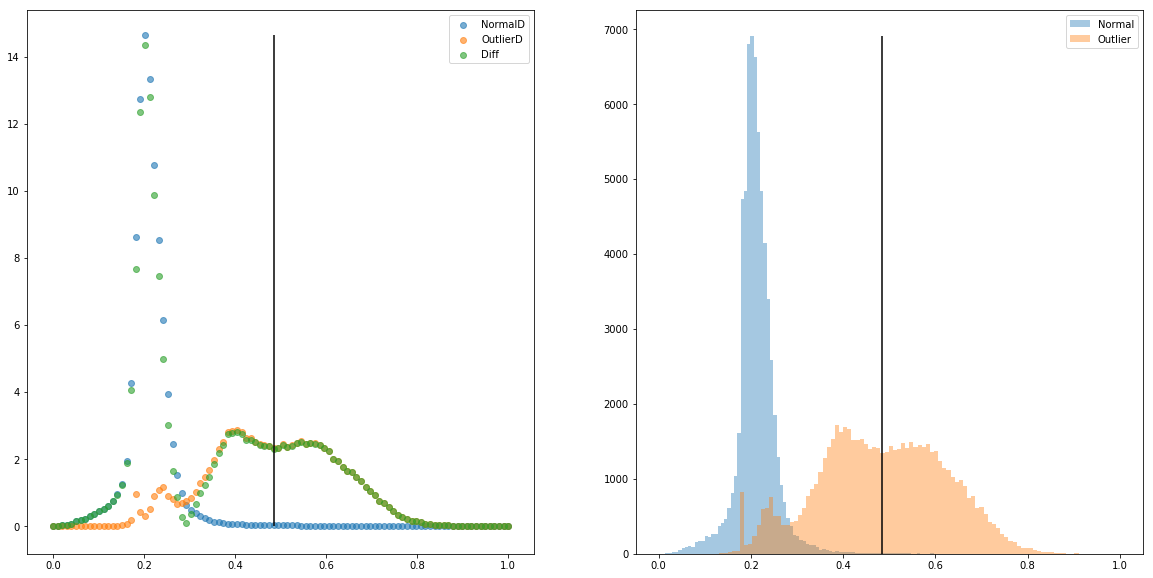

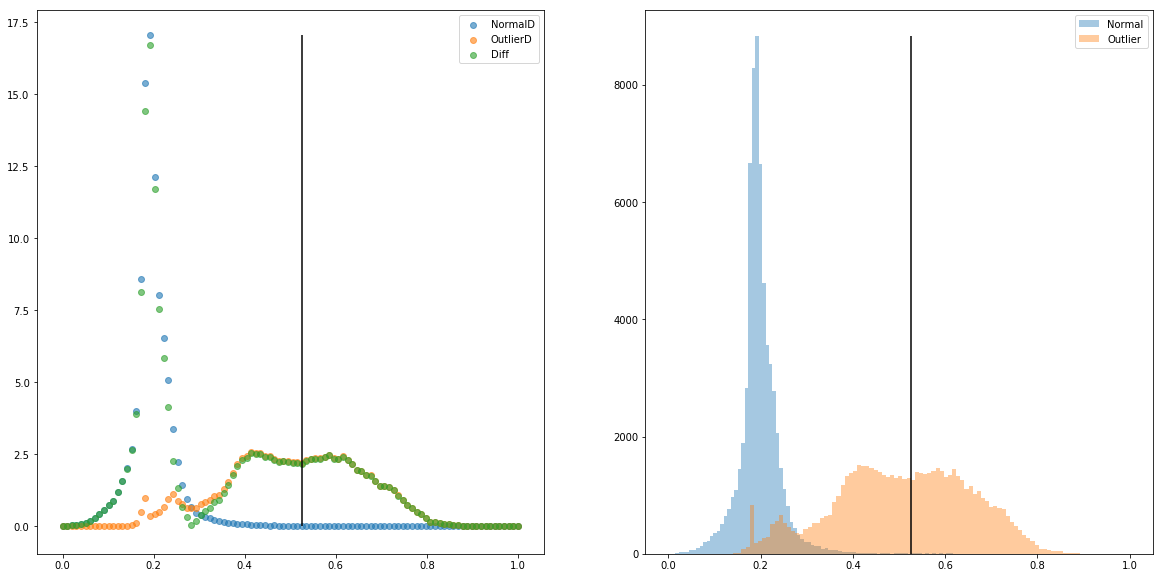

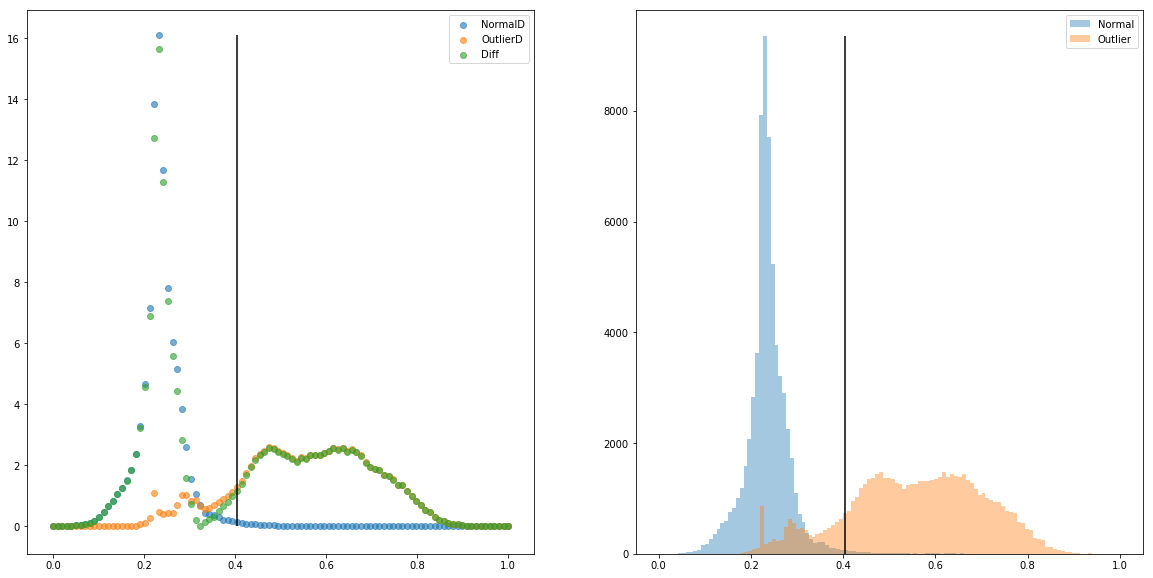

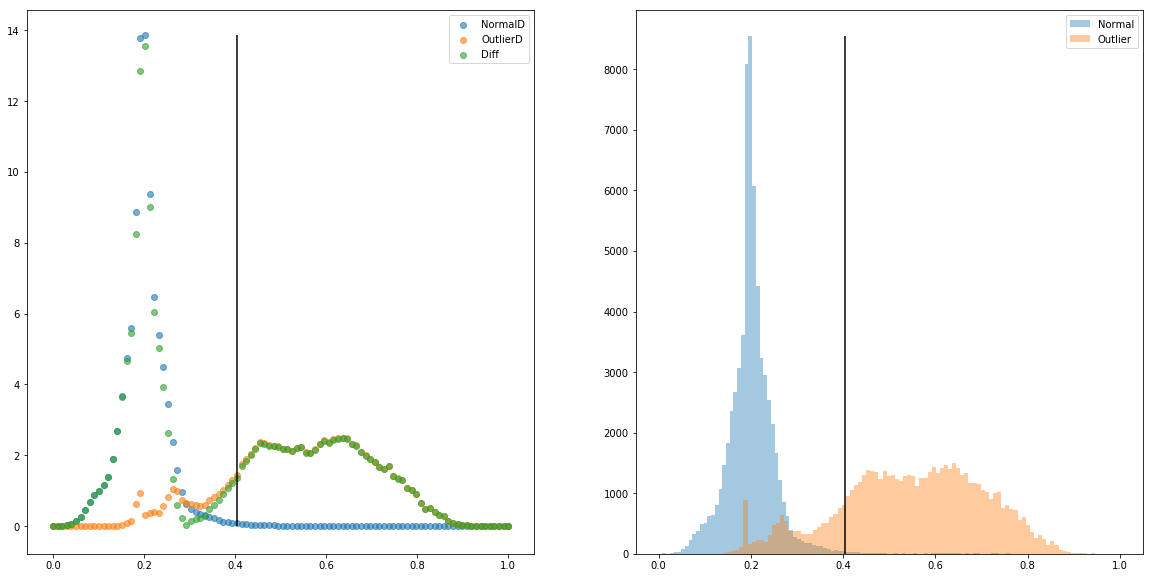

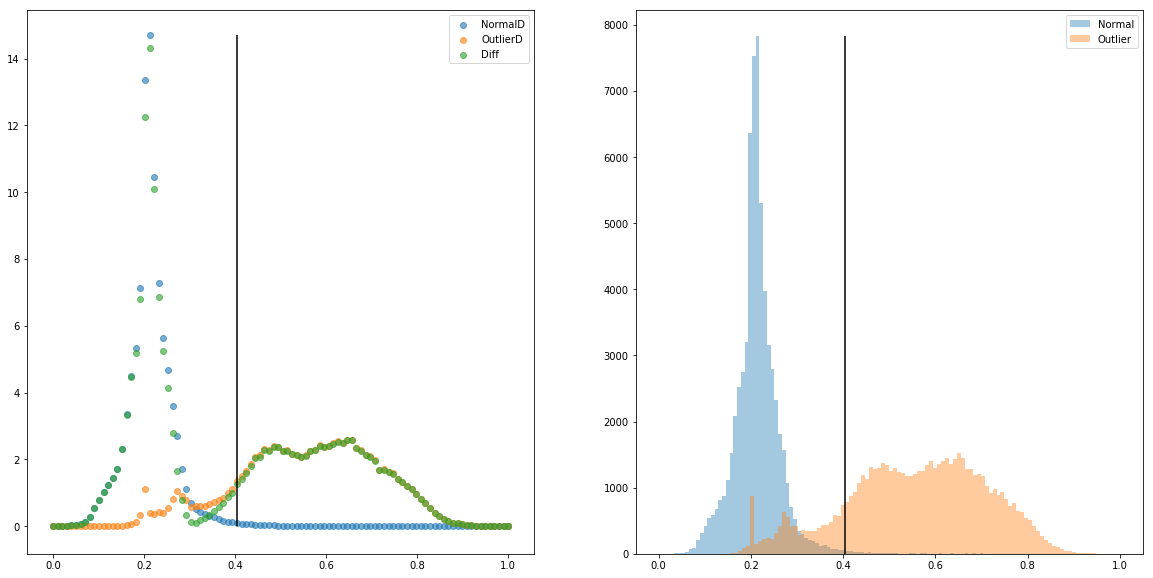

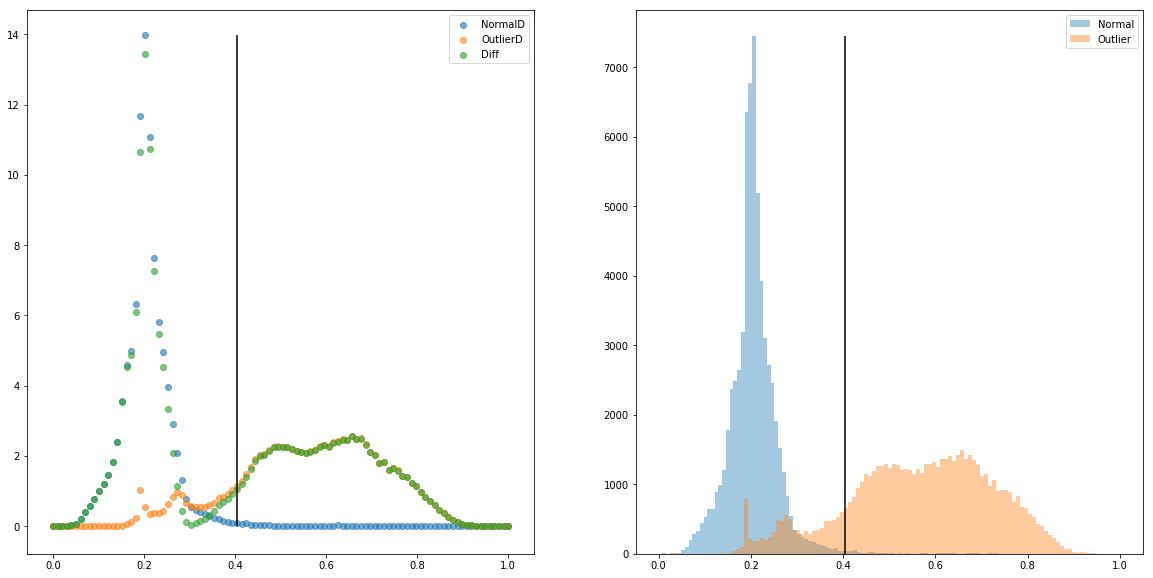

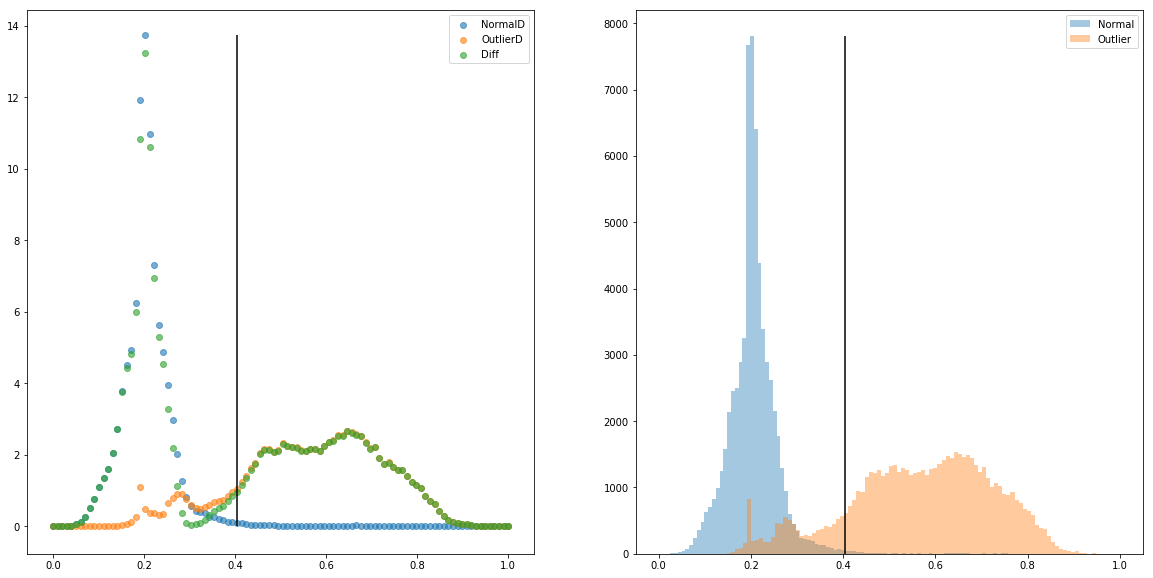

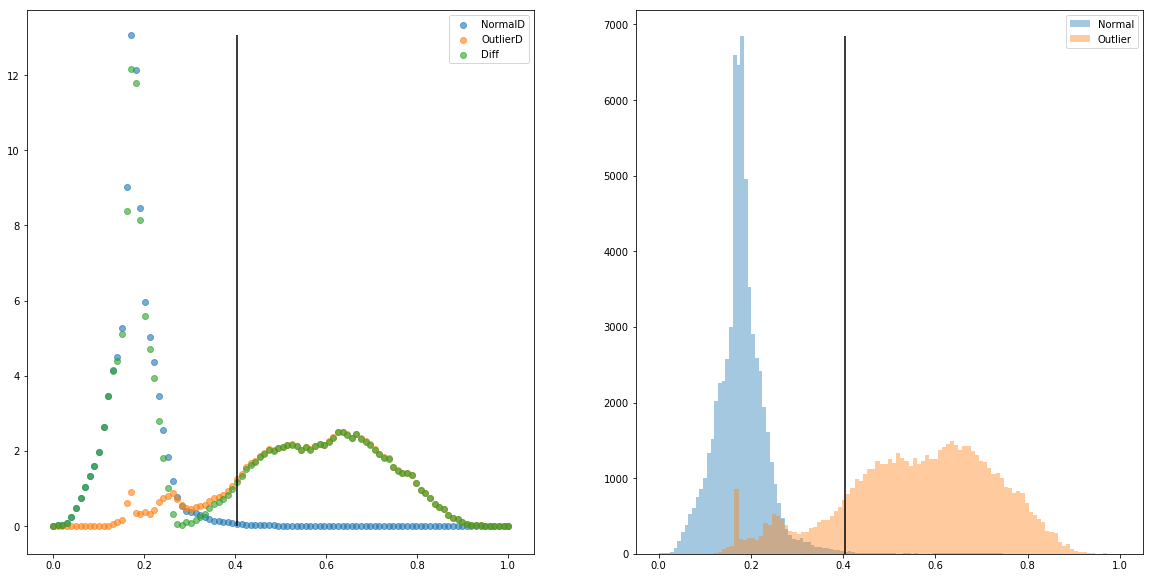

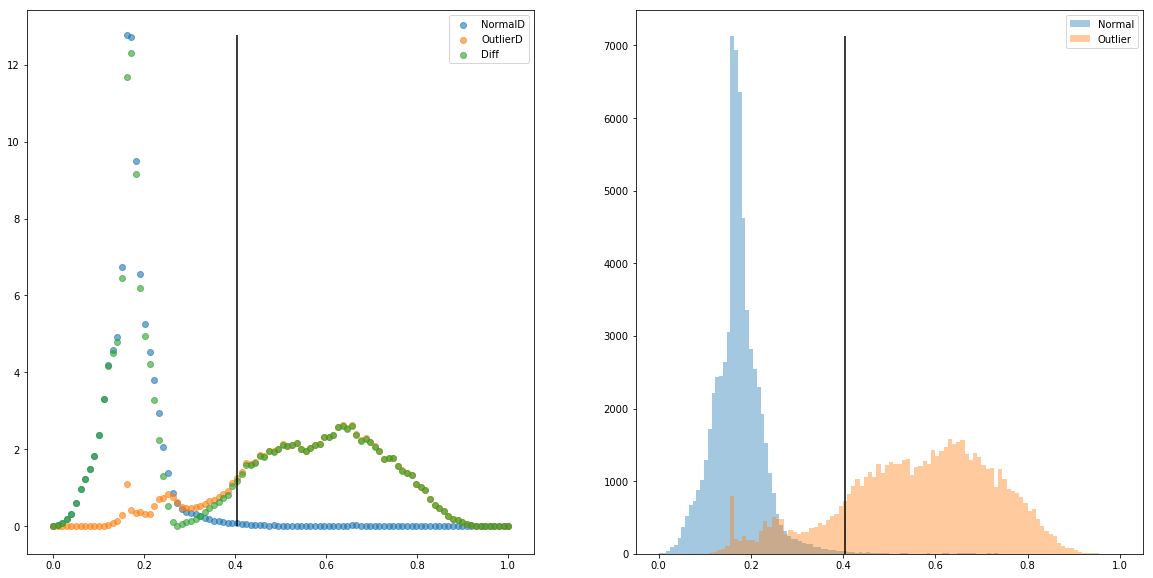

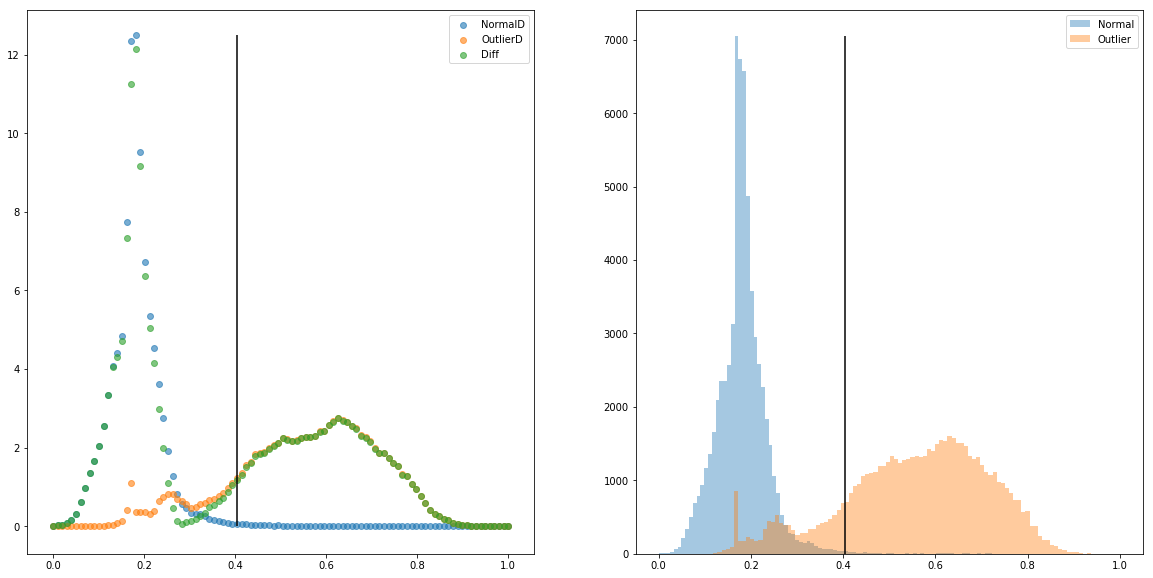

In [109]:
net = NeuralNetwork() 
Lvect,perfScores,CalibParams,diff = trainKDE(model=net,xTrain=ErrRawTrain,yTrain=ytrain,learningRate =0.01,epochs=20,batchsize=200,limit=40,Bins=100,h=.005)

## 3. Model Evaluation

In [325]:
# Results with 10 epochs training
STrain,scoresTrain  = evalPerf(net,ErrRawTrain,ytrain,'Train',CalibParams)
STest,scoresTest  = evalPerf(net,ErrRawTest,ytest,'Test',CalibParams)

-------------------Scores on Train set-------------------
Accuracy :  0.9288
Precision :  0.9917
Recall :  0.8649
F1-score: 0.9240


-------------------Scores on Test set-------------------
Accuracy :  0.8815
Precision :  0.7245
Recall :  0.4610
F1-score: 0.5635




In [ ]:
torch.save(net.state_dict(), r'C:\Users\nmadhar\Desktop\Conv_deep\Review\Model\modelRealData2709_KDE.h5')
path = r'C:\Users\nmadhar\Desktop\Conv_deep\Review\Model'
name = '\CalibParams2709_KDE.pkl'

f = open(path+name,"wb")

pickle.dump(CalibParams,f)
f.close()

path = r'C:\Users\nmadhar\Desktop\Conv_deep\Review\Model'
name = '\Lvect2709_KDE.pkl'

f = open(path+name,"wb")

pickle.dump(Lvect,f)
f.close()

path = r'C:\Users\nmadhar\Desktop\Conv_deep\Review\Model'
name = '\PerfScores2709_KDE.pkl'

f = open(path+name,"wb")

pickle.dump(perfScores,f)
f.close()


In [9]:
CalibParamsLoaded = load(r'C:\Users\nmadhar\Desktop\Conv_deep\Review\Model\CalibParams2709_KDE.pkl',allow_pickle=True)
netLoaded = NeuralNetwork()
netLoaded.load_state_dict(torch.load(r'C:\Users\nmadhar\Desktop\Conv_deep\Review\Model\modelRealData2709_KDE.h5'))

<All keys matched successfully>

In [10]:
# Results with 10 epochs training
STrain,scoresTrain  = evalPerf(netLoaded,ErrRawTrain,ytrain,'Train',CalibParamsLoaded)
STest,scoresTest  = evalPerf(netLoaded,ErrRawTest,ytest,'Test',CalibParamsLoaded)

-------------------Scores on Train set-------------------
Accuracy :  0.9283
Precision :  0.9920
Recall :  0.8635
F1-score: 0.9233


-------------------Scores on Test set-------------------
Accuracy :  0.8815
Precision :  0.7245
Recall :  0.4610
F1-score: 0.5635




## 4. PCA NN vs State of the art 

In [11]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import KNeighborsClassifier #Supervised
from sklearn.neural_network import MLPClassifier
from sklearn import svm # Supervised 
from sklearn.tree import DecisionTreeClassifier

from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from numpy import load, save
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from collections import Counter
import time
from sklearn.metrics import f1_score
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import numpy.linalg as npl
#from decomp_utils import *
#from pca_ad_utils1 import *
from numpy import load,save 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.neighbors import KernelDensity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_s

In [12]:
plt.rcParams["figure.figsize"] = (20,10)
import sys 
sys.path.append(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Code')
from pca_ad_utils import *
from decomp_utils import *
from customizedLossSynthetic import *

### a. Isolation Forest

In [13]:
# with balanced training and unbalanced test
clf_if_train = IsolationForest(random_state=0,contamination=0.5)

ypredTrainIF = redefine_if_lof_pred(clf_if_train.fit_predict(X_train))

s = time.time()
clf_if_test = IsolationForest(random_state=0,contamination=0.16)
ypredTestIF = redefine_if_lof_pred(clf_if_test.fit_predict(X_test))
timeIF  = time.time()-s
print(f'Exe. time :{timeIF}\n')

scoresTrainIF = evalalg(y_train,ypredTrainIF)
scoresTestIF = evalalg(y_test,ypredTestIF)


print(f'Accuracy on Train : {accuracy_score(y_train,ypredTrainIF)}')
print(f'Accuracy on Test : {accuracy_score(y_test,ypredTestIF)}\n')

print(f'Recall on Train : {recall_score(y_train,ypredTrainIF)}')
print(f'Recall on Test : {recall_score(y_test,ypredTestIF)}\n')

print(f'Precsion on Train : {precision_score(y_train,ypredTrainIF)}')
print(f'Precision on Test : {precision_score(y_test,ypredTestIF,pos_label=1)}\n')

print(f'F1-score on Train : {f1_score(y_train,ypredTrainIF)}')
print(f'F1-score on Test : {f1_score(y_test,ypredTestIF)}\n')

Exe. time :0.31126999855041504

Accuracy on Train : 0.5282493226591559
Accuracy on Test : 0.7316810344827587

Recall on Train : 0.5282493226591559
Recall on Test : 0.17532467532467533

Precsion on Train : 0.5282493226591559
Precision on Test : 0.18120805369127516

F1-score on Train : 0.5282493226591559
F1-score on Test : 0.17821782178217824



### b. LOF

In [ ]:
# with balanced training and unbalanced test


clf_lof_train = LocalOutlierFactor(n_neighbors=2,novelty= False,contamination=0.5)
ypredTrainLOF = redefine_if_lof_pred(clf_lof_train.fit_predict(X_train))

s = time.time()
clf_lof_test = LocalOutlierFactor(n_neighbors=2,novelty= False)
ypredTestLOF = redefine_if_lof_pred(clf_lof_test.fit_predict(X_test))
timeLOF  = time.time()-s

print(f'Exe. time :{timeLOF}')

print(f'Accuracy on Train : {accuracy_score(y_train,ypredTrainLOF)}')
print(f'Accuracy on Test : {accuracy_score(y_test,ypredTestLOF)}')


print(f'Recall on Train : {recall_score(y_train,ypredTrainLOF)}')
print(f'Recall on Test : {recall_score(y_test,ypredTestLOF)}\n')

print(f'Precsion on Train : {precision_score(y_train,ypredTrainLOF)}')
print(f'Precision on Test : {precision_score(y_test,ypredTestLOF,pos_label=1)}\n')

print(f'F1-score on Train : {f1_score(y_train,ypredTrainLOF)}')
print(f'F1-score on Test : {f1_score(y_test,ypredTestLOF)}\n')

In [14]:
s = time.time()
clf_lof_test = LocalOutlierFactor(n_neighbors=2,novelty= False)
ypredTestLOF = redefine_if_lof_pred(clf_lof_test.fit_predict(X_test))
timeLOF  = time.time()-s

print(f'Exe. time :{timeLOF}')

print(f'Accuracy on Test : {accuracy_score(y_test,ypredTestLOF)}')


print(f'Recall on Test : {recall_score(y_test,ypredTestLOF)}\n')

print(f'Precision on Test : {precision_score(y_test,ypredTestLOF,pos_label=1)}\n')

print(f'F1-score on Test : {f1_score(y_test,ypredTestLOF)}\n')

Exe. time :0.11084318161010742
Accuracy on Test : 0.8232758620689655
Recall on Test : 0.2662337662337662

Precision on Test : 0.44565217391304346

F1-score on Test : 0.3333333333333333



### c. KNN

In [17]:
s = time.time()

clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn.fit(X_train,y_train)

ypredTrainKNN = clf_knn.predict(X_train)

s = time.time()
ypredTestKNN = clf_knn.predict(X_test)
timeKNN  = time.time()-s

print(f'Exe. time :{timeKNN}')

print(f'Accuracy on Train : {accuracy_score(y_train,ypredTrainKNN)}')
print(f'Accuracy on Test : {accuracy_score(y_test,ypredTestKNN)}')

print(f'Recall on Train : {recall_score(y_train,ypredTrainKNN)}')
print(f'Recall on Test : {recall_score(y_test,ypredTestKNN)}\n')

print(f'Precsion on Train : {precision_score(y_train,ypredTrainKNN)}')
print(f'Precision on Test : {precision_score(y_test,ypredTestKNN,pos_label=1)}\n')

print(f'F1-score on Train : {f1_score(y_train,ypredTrainKNN)}')
print(f'F1-score on Test : {f1_score(y_test,ypredTestKNN)}\n')

Exe. time :33.99680280685425
Accuracy on Train : 0.9964334369116319
Accuracy on Test : 0.7025862068965517
Recall on Train : 0.9978876149948721
Recall on Test : 0.35064935064935066

Precsion on Train : 0.9949938185869748
Precision on Test : 0.23478260869565218

F1-score on Train : 0.9964386157984837
F1-score on Test : 0.28125



### d. DBSCAN

In [16]:
s = time.time()
clf_dbscan_test = DBSCAN(eps = .2, 
 metric='euclidean', 
 min_samples = 2,
 n_jobs = -1).fit_predict(xtest)

ypredTestDBSCAN = list(clf_dbscan_test)
timeDBSCAN  = time.time()-s

print(f'Exe. time :{timeDBSCAN}')

ypredTestDBSCAN  =  redefine_pred_DBSCAN(ypredTestDBSCAN)

print(f'Accuracy on Test : {accuracy_score(ytest,ypredTestDBSCAN)}')

print(f'Recall on Test : {recall_score(ytest,ypredTestDBSCAN)}\n')

print(f'Precision on Test : {precision_score(ytest,ypredTestDBSCAN,pos_label=1)}\n')

print(f'F1-score on Test : {f1_score(ytest,ypredTestDBSCAN)}\n')

Exe. time :0.11579298973083496
Accuracy on Test : 0.2273706896551724
Recall on Test : 0.8376623376623377

Precision on Test : 0.15712545676004872

F1-score on Test : 0.2646153846153846



### e. SVM


In [18]:
clf_svm = svm.SVC()
clf_svm.fit(xtrain,ytrain)
ypredTrainSVM = clf_svm.predict(xtrain)
s = time.time()
ypredTestSVM = clf_svm.predict(xtest)
timeSVM  = time.time()-s

print(f'Exe. time :{timeSVM}')


print(f'Accuracy on Train : {accuracy_score(ytrain,ypredTrainSVM)}' )
print(f'Accuracy on Test : {accuracy_score(ytest,ypredTestSVM)}' )

print(f'Recall on Train : {recall_score(ytrain,ypredTrainSVM)}')
print(f'Recall on Test : {recall_score(ytest,ypredTestSVM)}\n')

print(f'Precsion on Train : {precision_score(ytrain,ypredTrainSVM)}')
print(f'Precision on Test : {precision_score(ytest,ypredTestSVM,pos_label=1)}\n')

print(f'F1-score on Train : {f1_score(ytrain,ypredTrainSVM)}')
print(f'F1-score on Test : {f1_score(ytest,ypredTestSVM)}\n')

Exe. time :5.509619474411011
Accuracy on Train : 0.9684213748871099
Accuracy on Test : 0.5010775862068966
Recall on Train : 0.9526550230372423
Recall on Test : 0.961038961038961

Precsion on Train : 0.9836728887764941
Precision on Test : 0.24462809917355371

F1-score on Train : 0.9679155196814879
F1-score on Test : 0.38998682476943347



In [112]:
PathsSignatureTest.shape[0] * PathsSignatureTest.shape[1]

662820

In [113]:
PathsSignatureTrain.shape[0] * PathsSignatureTrain.shape[1]

3919740

In [114]:
xtest.shape

(22094, 206)

In [115]:
ytest.shape

torch.Size([928, 1])

### f. Signatures + IF 

In [88]:
from iisignature import sig

def ComputeSignatureDF(DF=None ,depth=2):
    n,d = DF.shape
    t = np.arange(d).reshape(-1,1)
    temp = np.zeros((d,2))
    dSig = sig(temp, depth).shape[0]
    PathsSignature = np.zeros((n,dSig))
    for i in range(n):
        temp = np.concatenate([t,DF[i,:].reshape(-1,1)],axis=1)
        PathsSignature[i,:] = sig(temp, depth)
    return PathsSignature

def flatlabels(TrueLabels,dimSign):
    n = len(TrueLabels)
    y_flat = np.zeros(n*dimSign)
    for i in range(n):
        y_flat[i*dimSign:(i+1)*dimSign] = np.ones(dimSign)*TrueLabels[i]
    return y_flat
depth = 4

In [116]:
PathsSignatureTrain =   ComputeSignatureDF(DF=X_train ,depth=depth)
PathsSignatureTest =   ComputeSignatureDF(DF=X_test ,depth=depth)

PathsSignatureTrainFlat = PathsSignatureTrain.reshape(-1,1)
PathsSignatureTestFlat = PathsSignatureTest.reshape(-1,1)

y_trainflat = flatlabels(np.array(y_train),PathsSignatureTrain.shape[1])
y_testflat = flatlabels(np.array(y_test),PathsSignatureTest.shape[1])

clf_if_train = IsolationForest(random_state=0,contamination=0.5)

ypredTrainIF = redefine_if_lof_pred(clf_if_train.fit_predict(PathsSignatureTrainFlat))

clf_if_test = IsolationForest(random_state=0,contamination=0.16)
ypredTestIF = redefine_if_lof_pred(clf_if_test.fit_predict(PathsSignatureTestFlat))

scoresTrainIF = evalalg(y_trainflat,ypredTrainIF)
scoresTestIF = evalalg(y_testflat,ypredTestIF)


In [118]:
scoresTrainIF

(0.5195563991489232,
 0.5171924668472909,
 0.5196492983711711,
 0.5184179718366623)

In [119]:
scoresTestIF

(0.7323635057471264,
 0.17467532467532468,
 0.18155230596175478,
 0.17804743519029234)

# II. Anomaly localization step 

## 1. Data import 

In [21]:
X_over_2018_2_1 = np.load(r'C:\Users\nmadhar\Desktop\Conv_deep\Review\Data\X_over_2018_2_1.npy')
y_over_2018_2_bool = np.load(r'C:\Users\nmadhar\Desktop\Conv_deep\Review\Data\y_over_2018_2_bool.npy')
X_2019_2_1 = np.load(r'C:\Users\nmadhar\Desktop\Conv_deep\Review\Data\X_2019_2_1.npy')
y_2019_2_bool = np.load(r'C:\Users\nmadhar\Desktop\Conv_deep\Review\Data\y_2019_2_bool.npy')
x_over2_2018_1, x_valid2_2018_1, y_over2_2018_bool, y_valid2_2018_bool  = train_test_split(X_over_2018_2_1, y_over_2018_2_bool, test_size=0.33, shuffle= True,random_state=11)

In [22]:
#oversampled set
print('x_over2_2018_1.shape:',x_over2_2018_1.shape)
print('x_valid2_2018_1.shape:',x_valid2_2018_1.shape)
print('y_over2_2018_bool.shape:',y_over2_2018_bool.shape)
print('y_valid2_2018_bool.shape:',y_valid2_2018_bool.shape)

x_over2_2018_1.shape: (44856, 206, 1)
x_valid2_2018_1.shape: (22094, 206, 1)
y_over2_2018_bool.shape: (44856, 206)
y_valid2_2018_bool.shape: (22094, 206)


In [36]:
ytrain_loc = np.argmax(y_over2_2018_bool,axis=1)
ytest_loc = np.argmax(y_2019_2_bool,axis=1)
sys.path.append(r'C:\Users\nmadhar\Desktop\Conv_deep\ToSubmit\Code')

from LocationAnomalyPCA import *

In [37]:
Xtrain = x_over2_2018_1.reshape(-1,206)
Xtest = X_2019_2_1.reshape(-1,206)
# with PCA approach
norms_train, norms_test =  modelPCALocation(Xtrain,Xtest,k)


100%|██████████████████████████████████████████████████████████████████████████| 14185/14185 [00:02<00:00, 5908.44it/s]


## 2. Model Evaluation

In [80]:
# with PCA approach
norms_train, norms_test =  modelPCALocation(Xtrain,Xtest,k)

pred_loc_train = dummyprediction(norms_train)
ScoresTrainPCA = EvaluationPred(yPred = pred_loc_train,yTrue=ytrain_loc)
s = time.time()
pred_loc_test = dummyprediction(norms_test)
timePCANN = time.time() - s

print(f'Exe. time :{timePCANN}\n')
ScoresTestPCA = EvaluationPred(yPred = pred_loc_test,yTrue=ytest_loc)


printRes(ScoresTrainPCA,'Train')
printRes(ScoresTestPCA,'Test')

100%|██████████████████████████████████████████████████████████████████████████| 14185/14185 [00:02<00:00, 5246.77it/s]


Exe. time :0.015385150909423828

------------Scores on Train-------------
Accuracy: 0.9948056001426788
Recall: 0.9948056001426788
Precision: 0.994858684535837
F1-score: 0.9948012976766297

------------Scores on Test-------------
Accuracy: 0.9605216778286922
Recall: 0.9605216778286922
Precision: 0.9621248163366525
F1-score: 0.9592675186838869



0

## 3. PCA NN vs State of the art 



In [75]:
#n = int(Xtrain.shape[0]*206)
xtrain_flat = Xtrain.reshape(Xtrain.shape[0]*Xtrain.shape[1],1).reshape(-1,1)
ytrain_flat = y_over2_2018_bool.reshape(y_over2_2018_bool.shape[0]*y_over2_2018_bool.shape[1],1).reshape(-1,1)
xtest_flat = Xtest.reshape(Xtest.shape[0]*Xtest.shape[1],1)[:].reshape(-1,1)
ytest_flat = y_2019_2_bool.reshape(y_2019_2_bool.shape[0]*y_2019_2_bool.shape[1],1)[:].reshape(-1,1)


### a. Isolation Forest


In [76]:

clf_if = IsolationForest(random_state=0).fit(xtrain_flat)
ypredTrainIF = redefine_if_lof_pred(clf_if.predict(xtrain_flat))
s = time.time()
ypredTestIF = redefine_if_lof_pred(clf_if.predict(xtest_flat))
timeIF = time.time() - s

print(f'Exe. time :{timeIF}\n')

print('-------------------Train score-------------------')
print_scores(ytrain_flat,ypredTrainIF)

print('-------------------Test score-------------------')
print_scores(ytest_flat,ypredTestIF)

Exe. time :86.83897805213928

-------------------Train score-------------------
Accuracy on Train : 0.9048122276073078
Recall on Train : 0.9931335830212235
Precision on Train : 0.048222193596714466
f1-score on Train : 0.09197832476310129

-------------------Test score-------------------
Accuracy on Train : 0.7850012490973988
Recall on Train : 0.9835741980965809
Precision on Train : 0.021733136646785126
f1-score on Train : 0.042526601986728724



### b. Local Outlier factor 

In [77]:
clf_lof = LocalOutlierFactor(n_neighbors=2,novelty= True)
clf_lof.fit(xtrain_flat)


ypredTrainLOF = redefine_if_lof_pred(clf_lof.predict(xtrain_flat))
s = time.time()
ypredTestLOF = redefine_if_lof_pred(clf_lof.predict(xtest_flat))
timeLOF = time.time()-s
print(f'Exe. time :{timeLOF}\n')
print('-------------------Train score-------------------')
print_scores(ytrain_flat,ypredTrainLOF)

print('-------------------Test score-------------------')
print_scores(ytest_flat,ypredTestLOF)

Exe. time :18.592370986938477

-------------------Train score-------------------
Accuracy on Train : 0.9532283241648356
Recall on Train : 0.036650615302300696
Precision on Train : 0.00420871542018033
f1-score on Train : 0.007550393364471817

-------------------Test score-------------------
Accuracy on Train : 0.870376542977506
Recall on Train : 0.09615791328868523
Precision on Train : 0.003713413754332089
f1-score on Train : 0.007150683351594486



### 3. KNN 

In [78]:
clf_knn = KNeighborsClassifier(n_neighbors=3)
clf_knn.fit(xtrain_flat,ytrain_flat)
ypredTrainKNN = clf_knn.predict(xtrain_flat)
s = time.time()
ypredTestKNN = clf_knn.predict(xtest_flat)
timeKNN = time.time()-s
print(f'Exe. time :{timeKNN}\n')
print('-------------------Train score-------------------')
print_scores(ytrain_flat,ypredTrainKNN)

print('-------------------Test score-------------------')
print_scores(ytest_flat,ypredTestKNN)

Exe. time :90.0499632358551

-------------------Train score-------------------
Accuracy on Train : 0.9999068215701247
Recall on Train : 0.9823657927590512
Precision on Train : 0.9984139571768438
f1-score on Train : 0.9903248643121215

-------------------Test score-------------------
Accuracy on Train : 0.9985055319614936
Recall on Train : 0.9558688755727881
Precision on Train : 0.783757225433526
f1-score on Train : 0.8612990312847388



### 4. DBSCAN

In [79]:
printRes(ScoresTrainPCA,'Train')
printRes(ScoresTestPCA,'Test')

------------Scores on Train-------------
Accuracy: 0.9949616550740146
Recall: 0.9949616550740146
Precision: 0.9950067021147325
F1-score: 0.9949568762216625

------------Scores on Test-------------
Accuracy: 0.9605216778286922
Recall: 0.9605216778286922
Precision: 0.9621248163366525
F1-score: 0.9592675186838869



0